In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion

import tree
import sympy as sym
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from data import all_atom
from scipy.spatial.transform import Rotation
from model import basis_utils

from omegaconf import OmegaConf
import importlib

Rigid = ru.Rigid
Rotation = ru.Rotation

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
from scipy.spatial.transform import Rotation

In [3]:
# Reloads any code changes to 
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [4]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 80

# Diffusion settings
diff_conf = conf.diffuser
diff_conf.diffuse_trans = True  # whether to diffuse translations
diff_conf.diffuse_rot = True  # whether to diffuse rotations
# Noise schedules
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

diff_conf.trans_align_t = True

# print(OmegaConf.to_yaml(conf))

### Load data

In [5]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 2772727
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/28D_09M_2022Y_19h_25m_12s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [64 64 64 64 64 64 64 64 64 64]


In [6]:
train_iter = iter(train_loader)
next_item = next(train_iter)
# next_item = tree.map_structure(lambda x: x[0], next_item)

In [7]:
se3diff = exp._diffuser
r3diff = se3diff._r3_diffuser
so3diff = se3diff._so3_diffuser

Text(0.5, 1.0, 'Variance of each coordinate of the ground truth translation score')

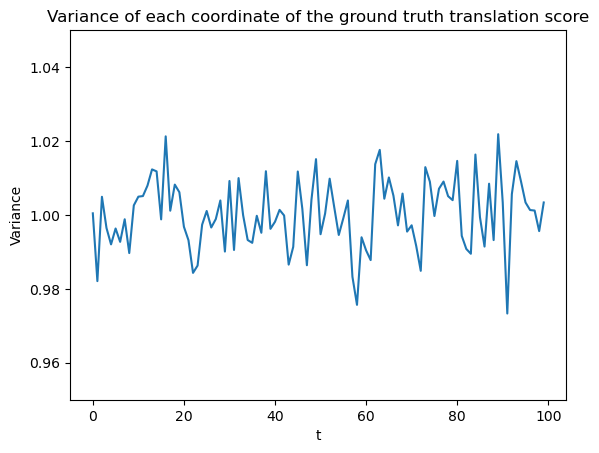

In [13]:
num_t = 10000
loc = np.zeros((num_t, 3))
sampled_scores = []
sampled_std = []
normalized_scores = []
discrete_t = np.linspace(1e-5, 1, 100)
for t in discrete_t:
    _, score_t, score_norm_std_t = r3diff.forward_marginal(loc, t, score_norm=True)
    # score_norm_std_t /= np.sqrt(3)
    sampled_scores.append(score_t)
    sampled_std.append(score_norm_std_t)
    normalized_scores.append(score_t / score_norm_std_t)
all_normalized_scores = np.stack(normalized_scores)

plt.plot(du.move_to_np(torch.mean(torch.var(torch.tensor(all_normalized_scores), axis=1), axis=-1)))
plt.xlabel('t')
plt.ylabel('Variance')
plt.ylim(0.95, 1.05)
plt.title('Variance of each coordinate of the ground truth translation score')

In [9]:
all_normalized_scores.shape

(100, 10000, 3)

In [88]:
num_t = 10000
loc = np.zeros((num_t, 3))
sampled_scores = []
sampled_std = []
normalized_scores = []
discrete_t = np.linspace(1e-3, 1, 100)
for t in discrete_t:
    _, score_t, score_norm_std_t = so3diff.forward_marginal(loc, t)
    score_norm_std_t /= np.sqrt(3)
    sampled_scores.append(score_t)
    sampled_std.append(score_norm_std_t)
    normalized_scores.append(score_t / score_norm_std_t)
all_normalized_scores = np.stack(normalized_scores)

Text(0.5, 1.0, 'Variance of each coordinate of the ground truth rotation score')

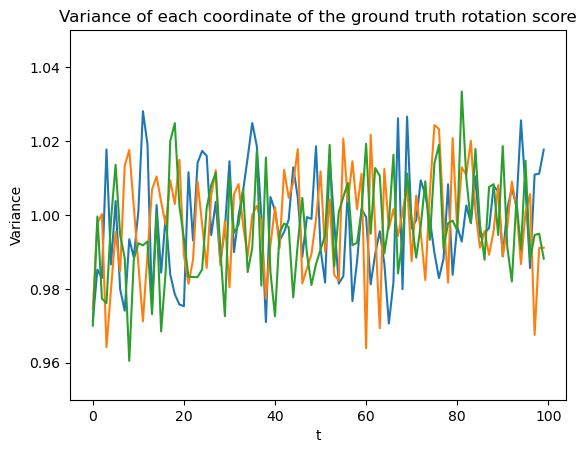

In [89]:
plt.plot(np.var(all_normalized_scores, axis=1))
plt.xlabel('t')
plt.ylabel('Variance')
plt.ylim(0.95, 1.05)
plt.title('Variance of each coordinate of the ground truth rotation score')

Text(0.5, 1.0, 'Expectation of score L2 norm')

INFO: Substituting symbol E from STIXNonUnicode
INFO: Substituting symbol E from STIXNonUnicode


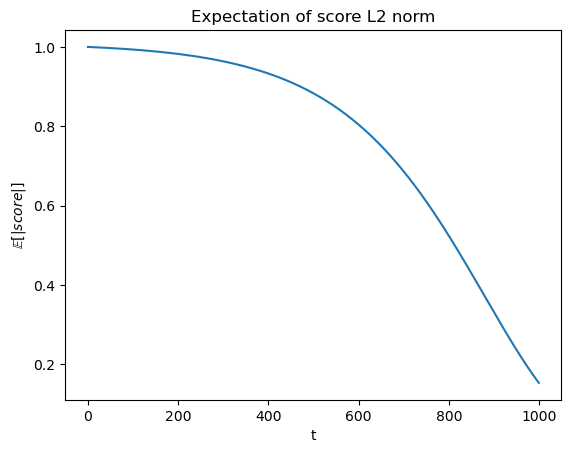

In [16]:
discrete_t = np.linspace(1e-3, 1, num_t)
b_t = np.exp(-1/2*r3diff.marginal_b_t(discrete_t))
plt.plot(b_t)
plt.xlabel('t')
plt.ylabel('$\mathbb{E}[\|score\|]$')
plt.title('Expectation of score L2 norm')

In [14]:
num_t = 1000
loc = np.zeros((num_t, 3))
exp_score_norms = []
discrete_t = np.linspace(1e-3, 1, num_t)
for t in discrete_t:
    _, score_t = r3diff.forward_marginal(loc, t, score_norm=False)
    scores_norm_t = np.linalg.norm(score_t, axis=-1)**2
    exp_score_norms.append(np.mean(scores_norm_t))

Text(0.5, 1.0, 'Expectation of score L2 norm')

INFO: Substituting symbol E from STIXNonUnicode
INFO: Substituting symbol E from STIXNonUnicode


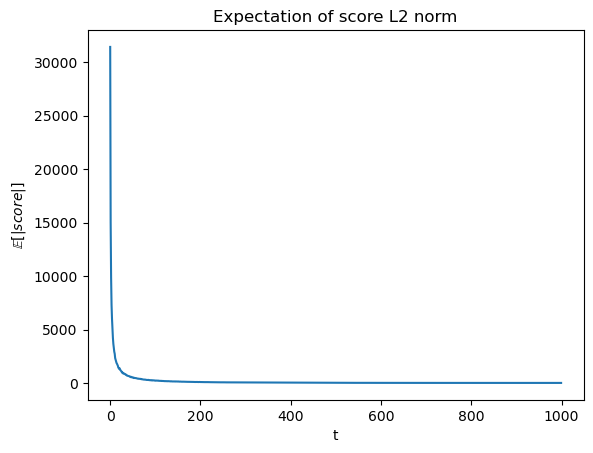

In [15]:
plt.plot(exp_score_norms)
plt.xlabel('t')
plt.ylabel('$\mathbb{E}[\|score\|]$')
plt.title('Expectation of score L2 norm')

In [ ]:
[r3diff.exp_score_norm(t) for t in ts]

Text(0.5, 1.0, 'Expectation of score L2 norm')

INFO: Substituting symbol E from STIXNonUnicode
INFO: Substituting symbol E from STIXNonUnicode


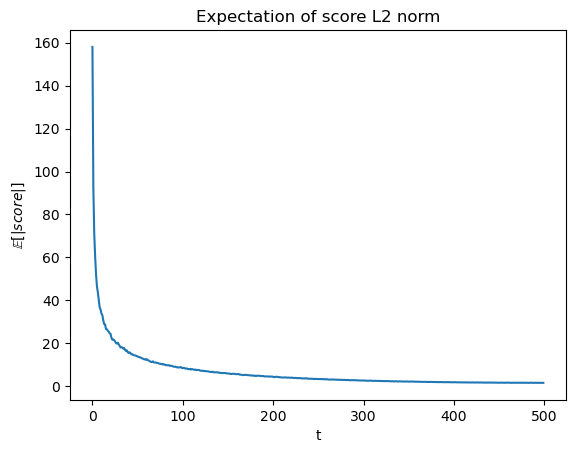

In [38]:
plt.plot([r3diff.exp_score_norm(t) for t in ts])
plt.xlabel('t')
plt.ylabel('$\mathbb{E}[\|score\|]$')
plt.title('Expectation of score L2 norm')

In [ ]:
plt.plot(1/(1 - np.exp(-b_t)))
plt.xlabel('t')
plt.ylabel(r'$\frac{1}{\sigma_t}$')
plt.title('inverse of std(t)')

In [43]:
ts = np.linspace(1e-3, 1.0, 500)
b_t = r3diff.marginal_b_t(ts)

Text(0.5, 1.0, 'inverse of std(t)')

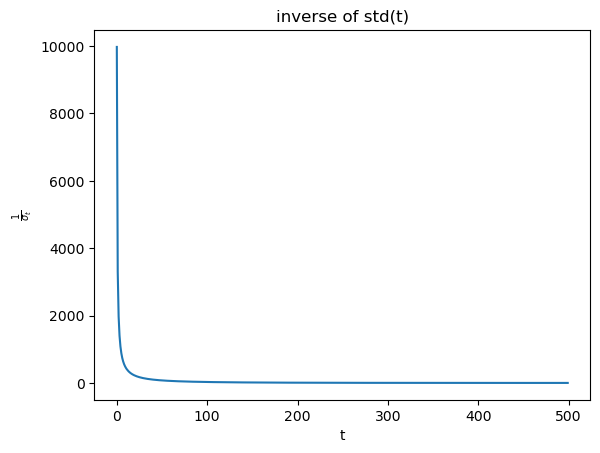

In [44]:
plt.plot(1/(1 - np.exp(-b_t)))
plt.xlabel('t')
plt.ylabel(r'$\frac{1}{\sigma_t}$')
plt.title('inverse of std(t)')

Text(0.5, 1.0, 'std(t)')

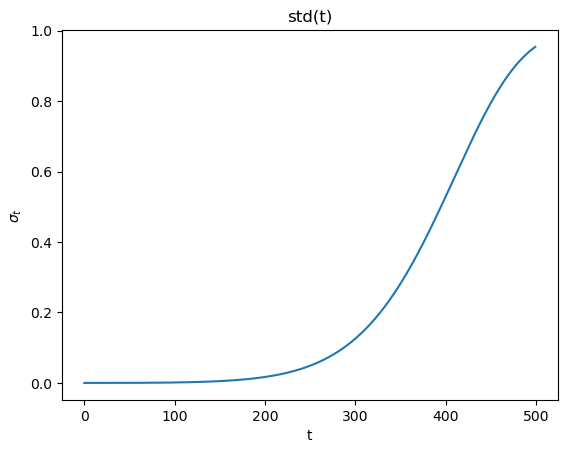

In [45]:
plt.plot((1 - np.exp(-b_t))**2)
plt.xlabel('t')
plt.ylabel(r'$\sigma_t$')
plt.title('std(t)')

Text(0.5, 1.0, 'x_0 coefficient')

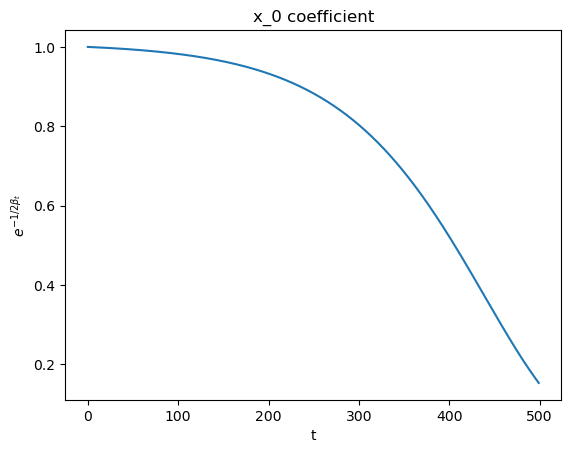

In [29]:
plt.plot(np.exp(-1/2*b_t))
plt.xlabel('t')
plt.ylabel(r'$e^{-1/2\beta_t}$')
plt.title('x_0 coefficient')

In [8]:
node_mask = next_item['res_mask']
edge_mask = node_mask[..., None] * node_mask[..., None, :]
rigids_tensor = next_item['rigids_t']
rigids = ru.Rigid.from_tensor_7(rigids_tensor)
atom_pos = all_atom.compute_backbone(
    rigids,
    torch.zeros(node_mask.shape + (2,))
)[0].to(node_mask.device)
bb_pos = atom_pos[..., :4, :]

In [11]:
num_neighbors = 2

In [12]:
batch_size, num_res = node_mask.shape
ca_pos = bb_pos[..., 1, :]
dists_2d = torch.linalg.norm(
    ca_pos[:, :, None, :] - ca_pos[:, None, :, :], axis=-1)

# Add bias to self-edges and masked residues.
dists_2d += torch.eye(num_res).to(node_mask.device)[None]*1e5
dists_2d += (1 - edge_mask)*1e5

# Calculate local graph features
_, local_graph = torch.topk(
    dists_2d, k=num_neighbors, dim=-1, largest=False)
# TODO: Add local in sequence order.
local_edge_mask = torch.gather(
    edge_mask * (1 - torch.eye(num_res))[None].to(edge_mask.device),
    -1,
    local_graph,
    sparse_grad=True
)

# Gather local features.
flat_local_graph = local_graph.view(batch_size, -1)
_, res_per_batch = flat_local_graph.shape
i_idx = torch.repeat_interleave(torch.arange(batch_size), res_per_batch)
j_idx = flat_local_graph.view(-1)
local_bb_pos = bb_pos[(i_idx, j_idx)].reshape(
    batch_size, num_res, num_neighbors, 4, 3)

In [26]:
rot = Rotation.random()

array([[ 0.26947431,  0.83576753,  0.4784101 ],
       [-0.61263013,  0.53207762, -0.58444651],
       [-0.74301273, -0.13559512,  0.65539762]])

In [43]:
ca_pos = torch.zeros((1, 3))
local_ca_pos = torch.eye(3)


In [37]:
rot = Rotation.random()
non_ca_pos = torch.tensor(rot.apply(np.eye(3)), dtype=ca_pos.dtype)

In [46]:
all_angles = []
for _ in range(100):
    rot = Rotation.random()
    non_ca_pos = torch.tensor(rot.apply(np.eye(3)), dtype=ca_pos.dtype)
    angles = all_atom.calculate_neighbor_angles(
        local_ca_pos - ca_pos,
        non_ca_pos
    )
    all_angles.append(angles)

In [47]:
all_angles

[tensor([2.1080, 2.1759, 0.9881]),
 tensor([1.5339, 1.4103, 1.3371]),
 tensor([1.3015, 2.0319, 2.0888]),
 tensor([1.1987, 1.4209, 1.9978]),
 tensor([1.9246, 1.4072, 1.1110]),
 tensor([2.8265, 0.5530, 2.5862]),
 tensor([2.2077, 0.7317, 2.3139]),
 tensor([1.4374, 1.9595, 1.7130]),
 tensor([1.9166, 1.7212, 1.6997]),
 tensor([1.3246, 1.6180, 2.1148]),
 tensor([2.2281, 0.8401, 2.2068]),
 tensor([1.9460, 1.0537, 1.5786]),
 tensor([2.1601, 1.9491, 1.3871]),
 tensor([0.6643, 0.6963, 0.7676]),
 tensor([1.4151, 1.0375, 1.7539]),
 tensor([1.9553, 1.7792, 1.8447]),
 tensor([1.1949, 2.1404, 1.6981]),
 tensor([0.0948, 0.2681, 0.3385]),
 tensor([0.0848, 0.3690, 0.2149]),
 tensor([2.1685, 1.0748, 1.9541]),
 tensor([0.6630, 2.7835, 2.3514]),
 tensor([0.1990, 2.3432, 2.7169]),
 tensor([2.0089, 1.4033, 2.0392]),
 tensor([1.8517, 0.9888, 1.6133]),
 tensor([2.0523, 1.0379, 2.0530]),
 tensor([1.5351, 1.0360, 1.5653]),
 tensor([0.8921, 0.9531, 0.8987]),
 tensor([1.4561, 1.0845, 1.8785]),
 tensor([1.4919, 1.0

In [23]:
all_atom.calculate_neighbor_angles(
    local_ca_pos - ca_pos,
    non_ca_pos[-1][None]
)

tensor([1.5708])

In [ ]:
calpha_vecs = (ca_pos[..., None, :] - local_ca_pos) + 1e-10
# Backbone pairwise displacements: [B, N, K, 3, 3]
bb_vecs = (non_ca_pos[..., None, :, :] - local_non_ca_pos) + 1e-10

# Calculate phi angles: [B, N, N, 3]
# where 3 is the number of non-Ca atoms per residue.
# phi_angles[a, b, c] is angle:
# c
# ^
# |
# |
# a ----> b
batch_size, num_res, num_neighbors, num_non_ca, _ = bb_vecs.shape
tiled_calpha_vecs = torch.tile(calpha_vecs[..., None, :], (1, 1, 1, num_non_ca, 1))
phi_angles = all_atom.calculate_neighbor_angles(
    tiled_calpha_vecs.reshape(-1, 3),
    bb_vecs.reshape(-1, 3)
).reshape(batch_size, num_res, num_neighbors, num_non_ca) 